# Shelter Animal Outcomes
* * *
### Problem Statement:
Predict the outcome of the animal as they leave the Animal Center based on thier breed, color, sex, and age.
These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

### Data Exploration
* * *

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
animals_train = pd.read_csv('train.csv', parse_dates=['DateTime'])
animals_train.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby


We will start by looking for missing data and decide how to deal with it

In [3]:
animals_train.shape

(26729, 10)

In [4]:
animals_train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

1. Only 50% of the data has __OutcomeSubtype__ value - not relevant in this phase.
2. There are 30% missing values for __Name__, 1 missing value for __SexuponOutcome__  and 18 missing values for __AgeuponOutcome__ - we will lable them as "unknown"

We are trying to predict the outcome type, to understand the behavior let's look at the outcome type count per value

Text(0.5,1,'OutcomeType percent of total ')

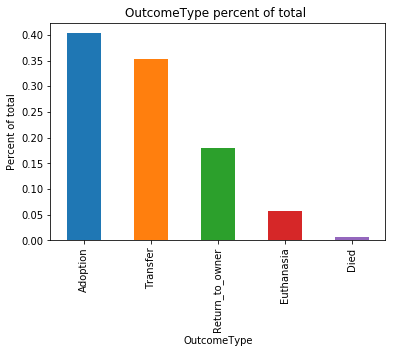

In [5]:
value_counts = animals_train['OutcomeType'].value_counts(normalize=True)
value_counts.plot(kind='bar')
plt.xlabel("OutcomeType")
plt.ylabel("Percent of total")
plt.title("OutcomeType percent of total ")

40% of the animals are adopted, about 35% are transferred, ~15% returned to owners and the rest are euthanized or die.

__AnimalType__:

which animal types does the animel shelter supports and their quantities:

In [6]:
animals_train.AnimalType.value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

In [7]:
animals_train.AnimalType.value_counts(normalize=True)

Dog    0.583449
Cat    0.416551
Name: AnimalType, dtype: float64

__Breed__:

Created a new column True if an animel is mixed breed (mix = unknown breeds):

In [8]:
animals_train['MixedBreed'] = animals_train.Breed.str.contains('Mix')

In [9]:
animals_train.MixedBreed.value_counts(normalize= True)

True     0.834225
False    0.165775
Name: MixedBreed, dtype: float64

outcome for dogs and cats which are mixed or not . i would expect that the unmixed animals would be more popular for adoption but we can see its not that important and mixed breeds get adopted mainly:

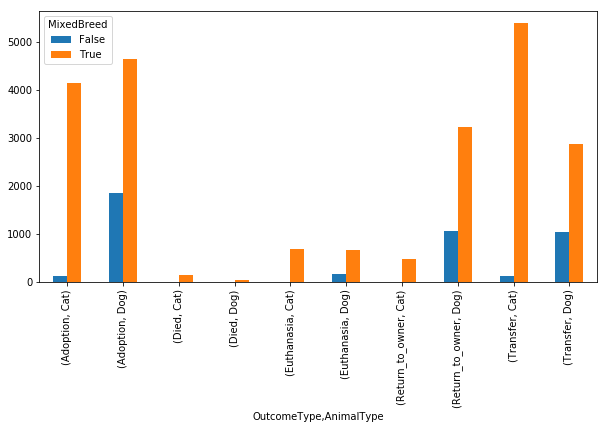

In [10]:
animals_train.groupby(['OutcomeType','AnimalType','MixedBreed',])['AnimalType'].count().unstack().plot(kind='bar',figsize=(10,5))

To analyze animals breeds we will try to separate mixed breed names into two different columns and concat them to one consolidated breeds vs. outcome list

In [11]:
def FirstBreed(Breed):
    if Breed != Breed:
        return 'Unknown'
    else:
        if '/' in Breed:
            return Breed.split('/')[0]
        elif 'Mix' in Breed:
            return Breed.split('Mix')[0]
        else:
            return Breed

def SecondBreed(Breed):
    if Breed != Breed:
        return 'Unknown'
    else:
        if '/' in Breed:
            return Breed.split('/')[1]
        elif 'Mix' in Breed:
            return Breed.split(' Mix')[1]

        
# Apply function and add new colorType column to dataset
animals_train['first_breed'] = animals_train.Breed.apply(FirstBreed)
animals_train['second_breed'] = animals_train.Breed.apply(SecondBreed)
animals_train

#Concat the separated breed list and create one breeds list
df1 = animals_train[['first_breed', 'OutcomeType']]
df1.columns = ['breed', 'OutcomeType']
df2 = animals_train[['second_breed', 'OutcomeType']]
df2.columns = ['breed', 'OutcomeType']
Breeds_df = pd.concat([df1,df2])
Breeds_df = Breeds_df[Breeds_df['breed'].notnull()]


In [12]:
Breeds_df.dropna(inplace=True)
mask = (Breeds_df['breed'].str.len() > 4)
Breeds_df = Breeds_df.loc[mask]

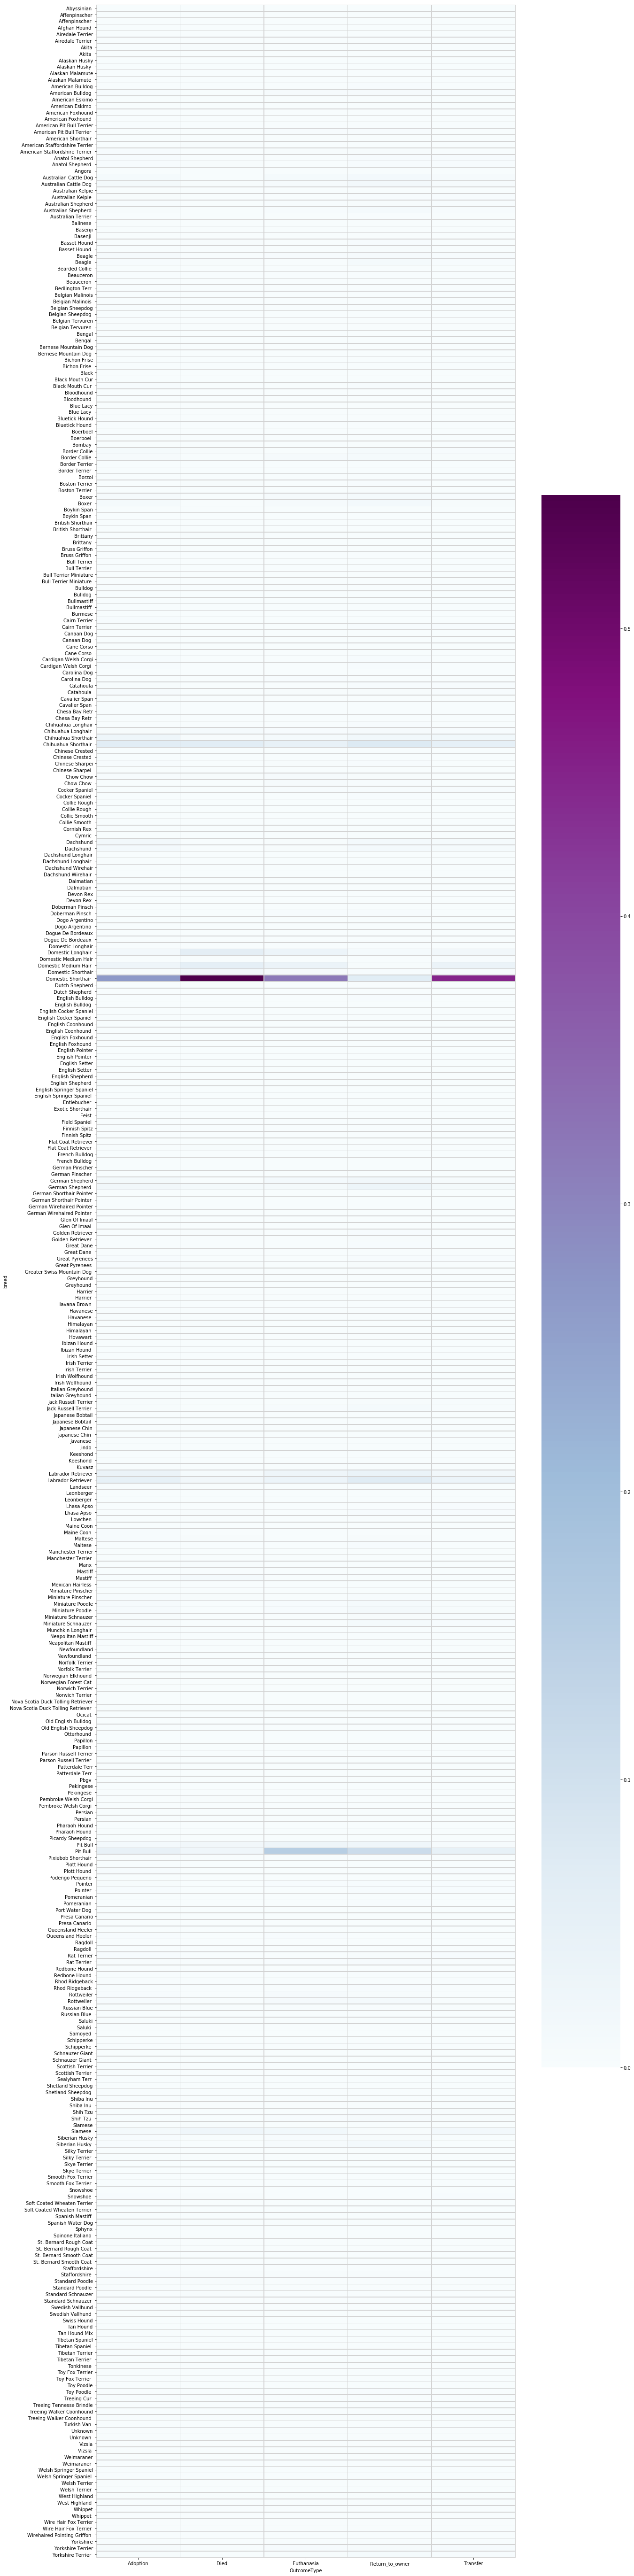

In [13]:
breeds_vs_outcome = pd.crosstab(index=Breeds_df['breed'],
                       columns=Breeds_df.OutcomeType,  
                       normalize='columns')

fig = plt.figure(figsize=(20, 100))
ax = fig.gca()
sns.heatmap(ax=ax, data=breeds_vs_outcome,
            linecolor='lightgrey', linewidths=.5, cmap='BuPu')

We can see that for "Domestic Shorthair" breed there is a higher chance to died or transfer

__DateTime__:

In order to analyze DateTime variable we will map the dates per month and season

In [14]:
animals_train['month'] = animals_train['DateTime'].dt.month

In [15]:
def to_season (x):
    
    if x in [5,6,7,8,9]:
        return 'Summer'
    if x in [10,11,12,1,2,3,4]:
        return 'Winter'

In [16]:
animals_train['Season'] = animals_train.month.map(to_season)

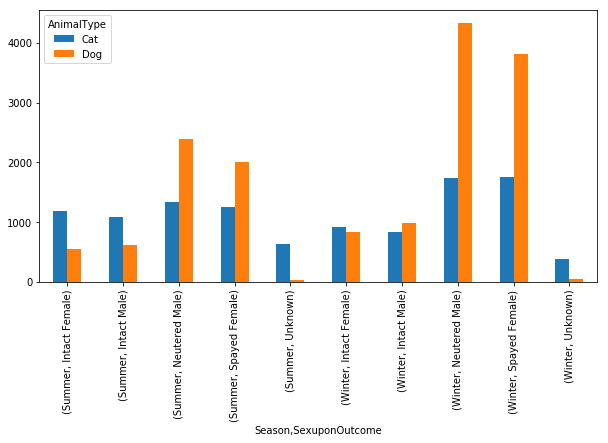

In [17]:
animals_train.groupby(['Season','SexuponOutcome','AnimalType'])['AnimalType'].count().unstack().plot(kind='bar',figsize=(10,5))

We can see an increase in the __winter__ months.

__Name__:

Name variable cannot provide good indication in the current structure but we might find out that having a name vs. unknown name has a different behavior, therefore we will add a new category variable "Name unknown" / "Name exist"

In [18]:
def name_category(name):
    if str(name)=='nan':
        return 'Name unknown'
    else:
        return 'Name exist'
    
animals_train['Name Category'] = animals_train.Name.apply(name_category)

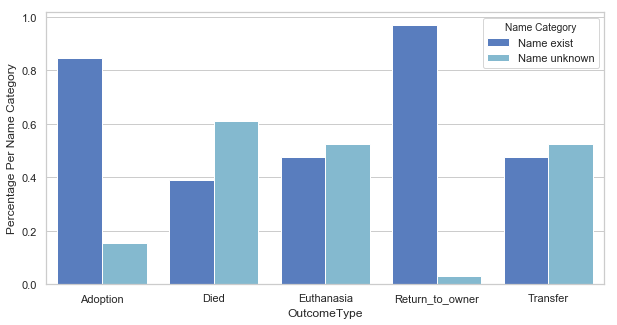

In [19]:
x, y, hue = "OutcomeType", "Percentage Per Name Category", "Name Category"
hue_order = ["Name exist", "Name unknown"]

colors = {'Name exist': '#4878CF', 'Name unknown':'#77BEDB'}

sns.set(style="whitegrid", palette="muted")

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, palette = colors)

We can see that having a name effect on the chances of the animal to be adopted or returned to owners, on the other hand the chances of the animal to die are higher when it doesnt have a name.

Let's test it for dogs and cats separately:

Text(0.5,1,'Cats')

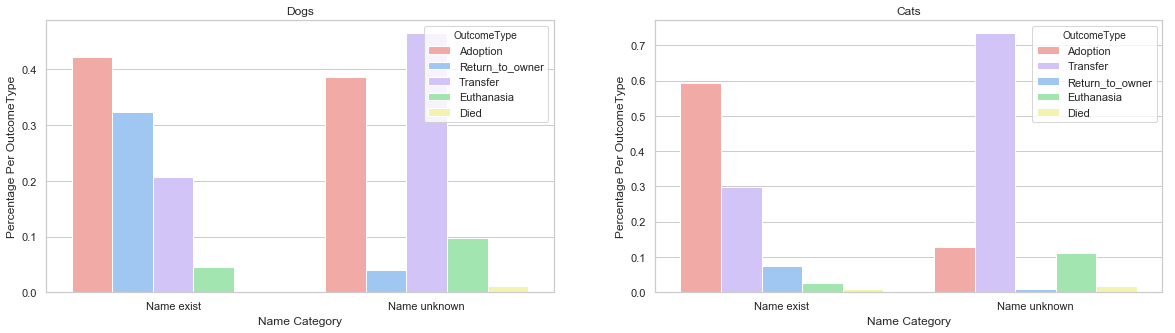

In [20]:
fig, ax =plt.subplots(1,2,figsize=(20,5))
colors = {'Return_to_owner': '#92C6FF', 'Euthanasia':'#97F0AA', 'Adoption':'#FF9F9A', 'Transfer':'#D0BBFF', 'Died':'#FFFEA3'}

sns.set(style="whitegrid", palette="pastel")

#Dogs
dogs = animals_train.loc[animals_train['AnimalType'] == "Dog"]
x, y, hue = "Name Category", "Percentage Per OutcomeType", "OutcomeType"
hue_order = ["Return_to_owner","Euthanasia","Adoption","Transfer","Died"]

percentage_df = (dogs[hue]
           .groupby(dogs[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, ax=ax[0], palette = colors).set_title('Dogs')

#Cats
cats = animals_train.loc[animals_train['AnimalType'] == "Cat"]
x, y, hue = "Name Category", "Percentage Per OutcomeType", "OutcomeType"
hue_order = ["Return_to_owner","Euthanasia","Adoption","Transfer","Died"]

percentage_df = (cats[hue]
           .groupby(cats[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, ax=ax[1], palette = colors).set_title('Cats')

Unknown name dogs have higher chance to be adopted then cats which have high % to be transferred.
Dogs with Name exist have high % to be returned to owners, more then cats.

__Age__ :

Age variable presented in different units, in order to analyze age parameter I will normalize units to years

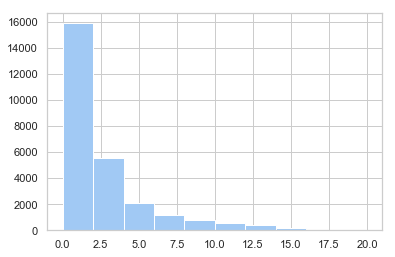

In [21]:
def age_in_years(age):
    if pd.isna(age):
        return 0
    if 'year' in age:
        return  int(age.split()[0])
    if 'month' in age:
        return int(age.split()[0]) / 12
    if 'week' in age:
        return int(age.split()[0]) / 52
    if 'day' in age:
        return int(age.split()[0]) / 365
    else: 
        return 0

# Apply function and add new normalized column to dataset
animals_train['Age In Years'] = animals_train.AgeuponOutcome.apply(age_in_years)
animals_train['Age In Years'].hist(bins = 10)

In [22]:
def age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
animals_train['AgeCategory'] = animals_train['Age In Years'].apply(age_category)

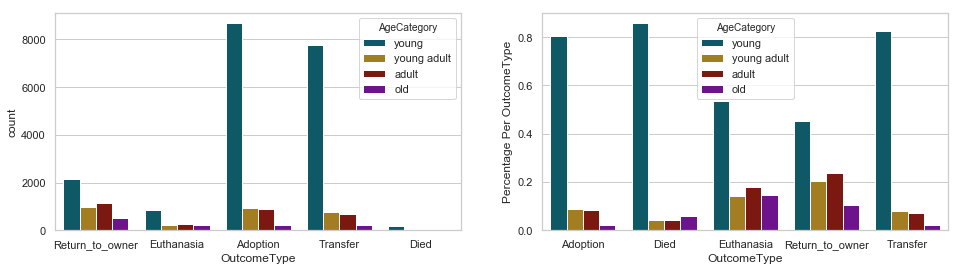

In [23]:
colors = {'young': '#006374', 'young adult':'#B8860B', 'adult':'#8C0900', 'old':'#7600A1'}

sns.set(style="whitegrid", palette="dark")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals_train, x='OutcomeType',hue='AgeCategory', ax=ax1, palette = colors)

x, y, hue = "OutcomeType", "Percentage Per OutcomeType", "AgeCategory"
hue_order = ["Return_to_owner","Euthanasia","Adoption","Transfer","Died"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, ax=ax2, palette = colors)

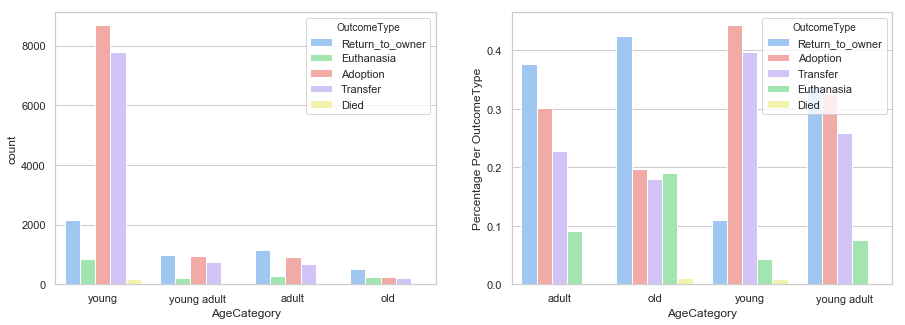

In [24]:
colors = {'Return_to_owner': '#92C6FF', 'Euthanasia':'#97F0AA', 'Adoption':'#FF9F9A', 'Transfer':'#D0BBFF', 'Died':'#FFFEA3'}
sns.set(style="whitegrid", palette="pastel")

fig, ax =plt.subplots(1,2,figsize=(15,5))

sns.countplot(data=animals_train, x='AgeCategory',hue='OutcomeType', palette = colors, ax=ax[0])


x, y, hue = "AgeCategory", "Percentage Per OutcomeType", "OutcomeType"
hue_order = ["young","young adult","adult","old"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, palette = colors, ax=ax[1])

Young cats and dogs have much higher chances to be adopted or transferred than to be returned to owner or something else, while older animals with approximately equal probability can be adopted, transferred or returned.

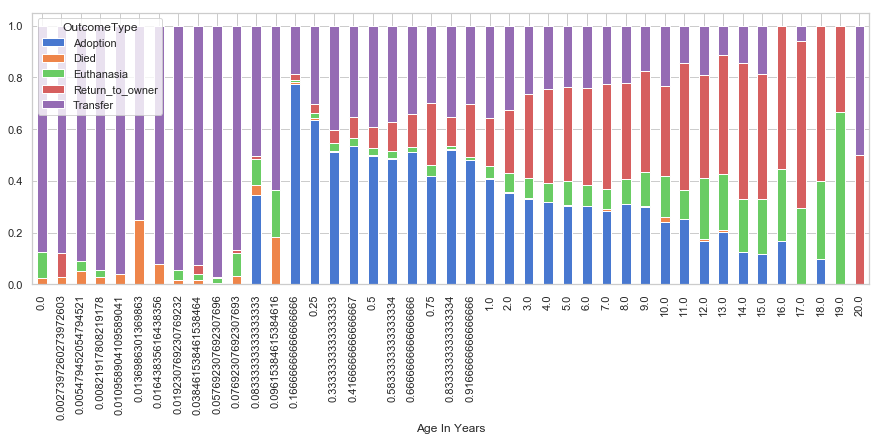

In [25]:
sns.set(style="whitegrid", palette="muted")
p_table = pd.pivot_table(animals_train,index='Age In Years',columns='OutcomeType',aggfunc='size')
p_table = p_table.div(p_table.sum(axis=1), axis=0)
p_table.plot.bar(stacked=True,figsize=(15,5))

we can see how the outcome changes as the age progresses. we can see the odds of an animal depending on its age.
In the first 6 months of the animal the most chance for the animal is to be transfered, after that we see that the adoption odds are getting higher and when animal is older odds to be returned to owner increases.

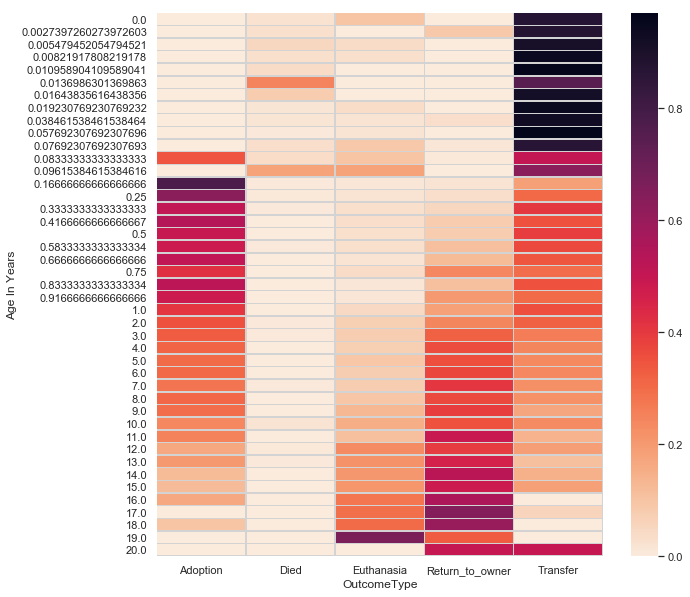

In [26]:
cmap = sns.cm.rocket_r

age_vs_outcome = pd.crosstab(index=animals_train['Age In Years'],
                       columns=animals_train.OutcomeType,  
                       normalize='index')

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
sns.heatmap(ax=ax, data=age_vs_outcome,
            linecolor='lightgrey', linewidths=.5, cmap=cmap)

Also in the heat map graph we can see a good visualization of the outcome chances upon animal age, as young as the animal is most chances are to be transferred, afterwards adopted and then returned to owner

__SexuponOutcome__:

__Animal Sex__ variable need to be extracted from the field SexuponOutcome

In [27]:
def Sex(SexuponOutcome):
    if SexuponOutcome != SexuponOutcome or  SexuponOutcome == 'Unknown':
        return 'Unknown'
    else:
        if float('Female' in SexuponOutcome):
            return 'Female'
        else:
            return 'Male'
        
# Apply function and add new sex column to dataset
animals_train['Animal_Sex'] = animals_train.SexuponOutcome.apply(Sex)

Text(0.5,1,'Animal Sex Count')

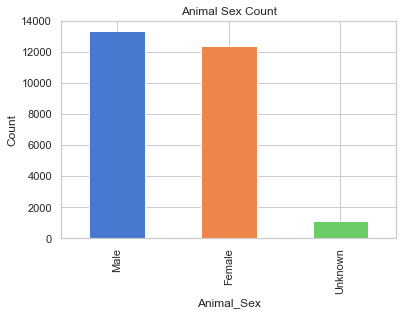

In [28]:
value_counts = animals_train['Animal_Sex'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel("Animal_Sex")
plt.ylabel("Count")
plt.title("Animal Sex Count")

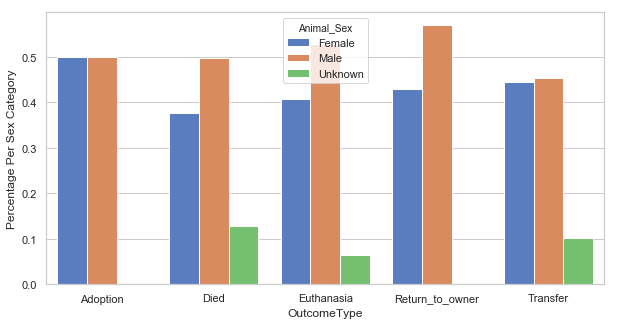

In [29]:
x, y, hue = "OutcomeType", "Percentage Per Sex Category", "Animal_Sex"
hue_order = ["Female'", "Male"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y, hue=hue, data=percentage_df)

Male and Female % for adoption is equal, % males that was returned to owners is higher.

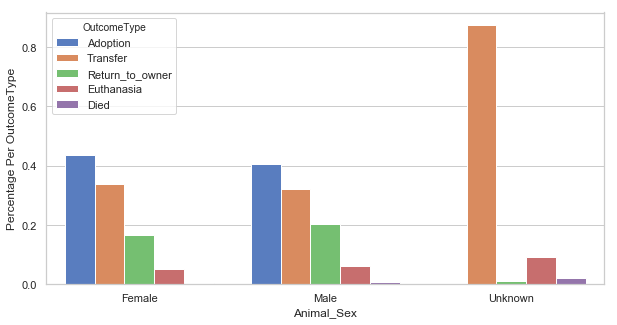

In [30]:
x, y, hue = "Animal_Sex", "Percentage Per OutcomeType", "OutcomeType"
hue_order = ["Return_to_owner","Euthanasia","Adoption","Transfer","Died"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y, hue=hue, data=percentage_df)

__Is Spayed/Neutered__ variable need to be extracted from the field SexuponOutcome

In [31]:
def Is_Spayed_Neutered(SexuponOutcome):
    if SexuponOutcome != SexuponOutcome or  SexuponOutcome == 'Unknown':
        return 'Unknown'
    else:
        if float('Intact' in SexuponOutcome):
            return 'Intact'
        else:
            return 'Spayed/Neutered'
        
# Apply function and add new Is_Spayed_Neutered column to dataset
animals_train['Animal_Spayed_Neutered'] = animals_train.SexuponOutcome.apply(Is_Spayed_Neutered)

Text(0.5,1,'Animal Spayed/Neutered Count')

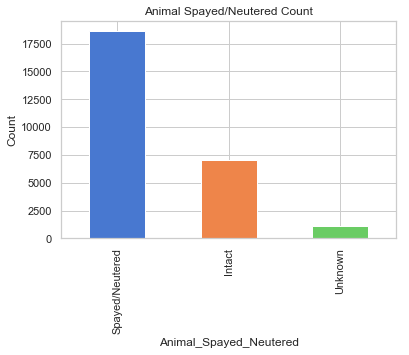

In [32]:
value_counts = animals_train['Animal_Spayed_Neutered'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel("Animal_Spayed_Neutered")
plt.ylabel("Count")
plt.title("Animal Spayed/Neutered Count")

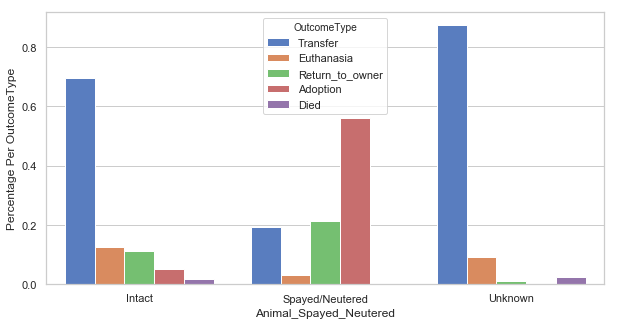

In [33]:
x, y, hue = "Animal_Spayed_Neutered", "Percentage Per OutcomeType", "OutcomeType"
hue_order = ["Return_to_owner","Euthanasia","Adoption","Transfer","Died"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y, hue=hue, data=percentage_df)

We can see there is a higher chance for an animal to be adopted/returned to owner in case it is spayed/neutered and a higher chance for the animal to be transferred in case it is intact/unknown

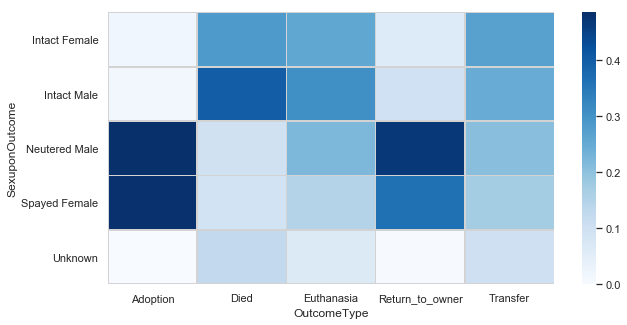

In [34]:
sexuponOutcome_vs_outcome = pd.crosstab(index=animals_train['SexuponOutcome'],
                       columns=animals_train.OutcomeType,  
                       normalize='columns')

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
sns.heatmap(ax=ax, data=sexuponOutcome_vs_outcome,
            linecolor='lightgrey', linewidths=.5, cmap='Blues')

Looking at the heat map we can see clearly that neutered/spayed males/females have high chance to be adopted and returned to owner

__Color__:

In order to analyze color variable we will add new column to compare between mixed color vs. solid color

In [35]:
def colorType(Color):
    if Color != Color:
        return 'Unknown'
    else:
        if '/' in Color:
            return 'Mixed'
        else:
            return 'Solid'
        
# Apply function and add new colorType column to dataset
animals_train['color_type'] = animals_train.Color.apply(colorType)

Text(0.5,1,'OutcomeType percent of total ')

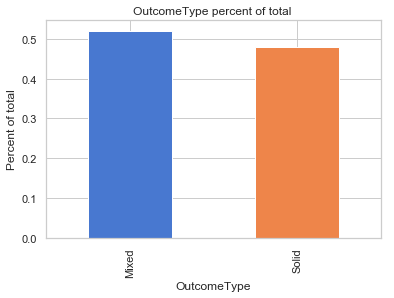

In [36]:
value_counts = animals_train['color_type'].value_counts(normalize=True)
value_counts.plot(kind='bar')
plt.xlabel("OutcomeType")
plt.ylabel("Percent of total")
plt.title("OutcomeType percent of total ")

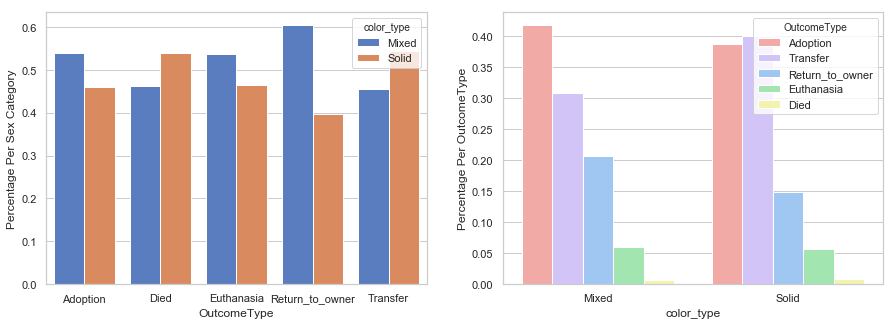

<Figure size 1440x360 with 0 Axes>

In [37]:
fig, ax =plt.subplots(1,2,figsize=(15,5))

x, y, hue = "OutcomeType", "Percentage Per Sex Category", "color_type"
hue_order = ["Mixed'", "Solid"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

plt.figure(figsize=(20,5))
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, ax=ax[0])

colors = {'Return_to_owner': '#92C6FF', 'Euthanasia':'#97F0AA', 'Adoption':'#FF9F9A', 'Transfer':'#D0BBFF', 'Died':'#FFFEA3'}
sns.set(style="whitegrid", palette="pastel")


x, y, hue = "color_type", "Percentage Per OutcomeType", "OutcomeType"
hue_order = ["Mixed","Solid"]

percentage_df = (animals_train[hue]
           .groupby(animals_train[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=percentage_df, palette = colors, ax=ax[1])

We can see that Mixed color have higher % of returned to owner where solid have higher % to transfer.

__Date Hour Category:__

Adding category of hour of the day

In [38]:
animals_train['Date_hour'] = animals_train['DateTime'].dt.hour
animals_train.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,second_breed,month,Season,Name Category,Age In Years,AgeCategory,Animal_Sex,Animal_Spayed_Neutered,color_type,Date_hour
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,,2,Winter,Name exist,1.0,young,Male,Spayed/Neutered,Mixed,18
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,,10,Winter,Name exist,1.0,young,Female,Spayed/Neutered,Solid,12


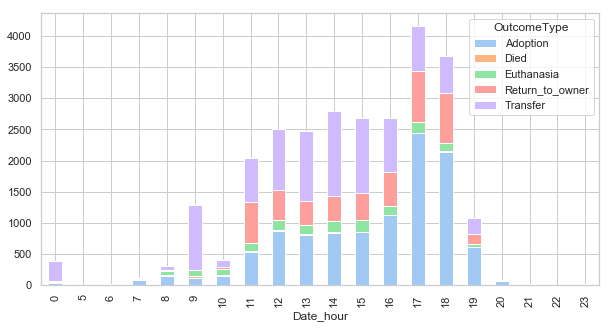

In [39]:
animals_train.groupby(['Date_hour','OutcomeType'])['OutcomeType'].count().unstack().plot(stacked = True,kind='bar',figsize=(10,5))

In [40]:
def Date_Part(x):
    if x > 7 and x < 11 : return 'morning'
    if x > 10 and x < 17: return 'midday'
    if x > 16 and x < 20: return 'lateday'
    else: return 'night'

animals_train['DateHourCategory'] = animals_train['Date_hour'].apply(Date_Part)
animals_train.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,month,Season,Name Category,Age In Years,AgeCategory,Animal_Sex,Animal_Spayed_Neutered,color_type,Date_hour,DateHourCategory
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,2,Winter,Name exist,1.0,young,Male,Spayed/Neutered,Mixed,18,lateday
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,10,Winter,Name exist,1.0,young,Female,Spayed/Neutered,Solid,12,midday


__Top Breeds:__

Since there are too many unique breeds we will take  the most popular breeds (15% of breeds cover 75% of the data). All the rest of the breeds will be grouped to one group named "other".

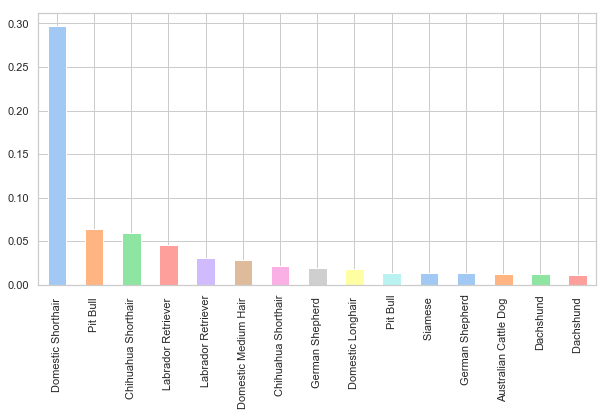

In [41]:
Breeds_df['breed'].value_counts( sorted).nlargest(15).plot(kind = 'bar',figsize=(10,5))

In [42]:
Breeds_df.head()

,breed,OutcomeType
0,Shetland Sheepdog,Return_to_owner
1,Domestic Shorthair,Euthanasia
2,Pit Bull,Adoption
3,Domestic Shorthair,Transfer
4,Lhasa Apso,Transfer


Since cats and dogs tend to have different outcomes we will do two separate breeds list per animal type

In [43]:
animals_train_Cats = animals_train[animals_train['AnimalType'] == 'Cat' ]
animals_train_Dogs = animals_train[animals_train['AnimalType'] == 'Dog' ]

In [44]:
#Cats
#Concat the separated breed list and create one breeds list
df1 = animals_train_Cats[['first_breed', 'OutcomeType']]
df1.columns = ['breed', 'OutcomeType']
df2 = animals_train_Cats[['second_breed', 'OutcomeType']]
df2.columns = ['breed', 'OutcomeType']
Breeds_df = pd.concat([df1,df2])
Breeds_df = Breeds_df[Breeds_df['breed'].notnull()]

Breeds_df.dropna(inplace=True)
mask = (Breeds_df['breed'].str.len() > 4)
Breeds_df = Breeds_df.loc[mask]

breeds_list_cats = Breeds_df.breed.value_counts().nlargest(10).index

In [45]:
#Dogs
#Concat the separated breed list and create one breeds list
df1 = animals_train_Dogs[['first_breed', 'OutcomeType']]
df1.columns = ['breed', 'OutcomeType']
df2 = animals_train_Dogs[['second_breed', 'OutcomeType']]
df2.columns = ['breed', 'OutcomeType']
Breeds_df = pd.concat([df1,df2])
Breeds_df = Breeds_df[Breeds_df['breed'].notnull()]

Breeds_df.dropna(inplace=True)
mask = (Breeds_df['breed'].str.len() > 4)
Breeds_df = Breeds_df.loc[mask]

breeds_list_dogs = Breeds_df.breed.value_counts().nlargest(50).index

In [46]:
def TopBreed (x, breeds_list):
    if '/' in x:
        if x.split('/')[0] in breeds_list:
            return x.split('/')[0].strip()
        elif x.split('/')[1] in breeds_list:
            return x.split('/')[1].strip()
        else:
            return 'Other'     
    elif 'Mix' in x:
        if x.split('Mix')[0] in breeds_list:
            return x.split('Mix')[0].strip()
        else:
            return 'Other'     
    else:
        if x.strip() in breeds_list:
            return x
        else:
            return 'Other'        

c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


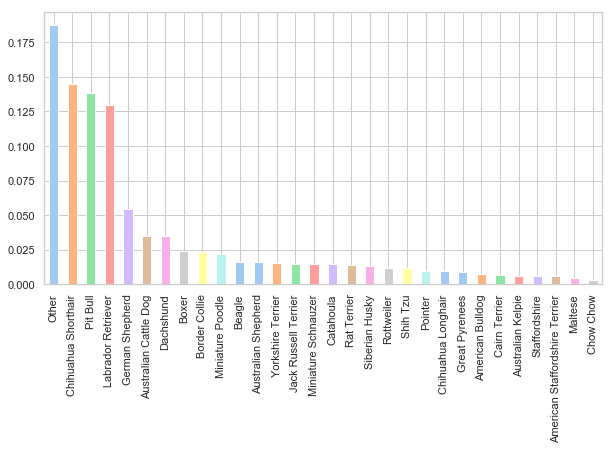

In [47]:
#Dogs - Add breed category
animals_train_Dogs['BreedCategory'] = animals_train_Dogs['Breed'].apply(TopBreed, args=(breeds_list_dogs,))
animals_train_Dogs['BreedCategory'].value_counts( sorted).plot(kind = 'bar',figsize=(10,5))

c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


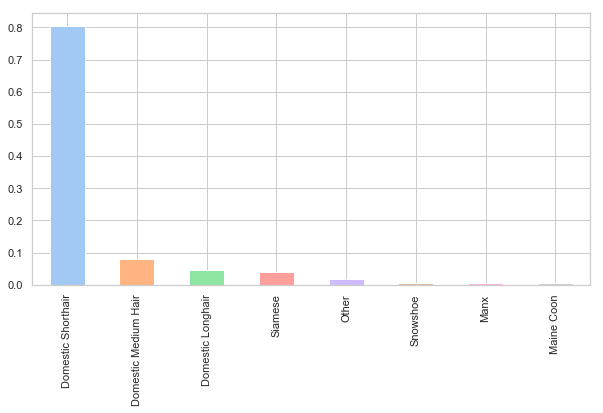

In [48]:
#Cats - Add breed category
animals_train_Cats['BreedCategory'] = animals_train_Cats['Breed'].apply(TopBreed, args=(breeds_list_cats,))
animals_train_Cats['BreedCategory'].value_counts( sorted).plot(kind = 'bar',figsize=(10,5))

# Modelling
* * *

We ran the models on the entire data and realized that each animal type behaves differently, therefore we got better result when adjusting different model per animal type.
As a first step we separate the data per animal type:

In [49]:
#Dogs Explanatory variables
animals_train_Dogs_classification = pd.get_dummies(animals_train_Dogs[['MixedBreed', 'month', 'Season', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory','BreedCategory']], drop_first=True)

#Cats Explanatory variables
animals_train_Cats_classification = pd.get_dummies(animals_train_Cats[['MixedBreed', 'month', 'Season', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory','BreedCategory']], drop_first=True)

In order to evaluate the models results we will use the below function and try to maximize the accuracy score

In [50]:
def evaluate_model(Classifier, X, y, X_t, **kwargs):

    # Fit the model
    Evaluated_Classifier = Classifier(**kwargs).fit(X, y)
    
    # Assess the model
    train_acc = accuracy_score(y_true=y_train,y_pred=Evaluated_Classifier.predict(X))
    test_acc = accuracy_score(y_true=y_test,y_pred=Evaluated_Classifier.predict(X_t))
    
    print("Train accuracy: {:.2f}".format(train_acc))
    print("Test accuracy : {:.2f}".format(test_acc))
    print()

## Cats Model:

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X = animals_train_Cats_classification
y = animals_train_Cats['OutcomeType'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=282)

c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Random Forest

In [52]:
#---------RandomForestClassifier-------------
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'sqrt', criterion='entropy',n_estimators=50)
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'auto', criterion='gini',n_estimators=500, oob_score =True, max_depth =15)
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'log2', criterion='gini',n_estimators=400, max_depth =15)

Train accuracy: 0.97
Test accuracy : 0.77

Train accuracy: 0.92
Test accuracy : 0.79

Train accuracy: 0.92
Test accuracy : 0.78



#### Random Forest with PCA

In [53]:
from sklearn.decomposition import PCA

for n in range (15,24):
    pca_transformer = PCA(n_components=n).fit(X_train)
    X_train_pca = pca_transformer.transform(X_train)
    X_test_pca = pca_transformer.transform(X_test)
    evaluate_model(RandomForestClassifier, X_train_pca, y_train,X_test_pca, max_features= 'auto', criterion='gini',n_estimators=500, oob_score =True, max_depth =15)

Train accuracy: 0.94
Test accuracy : 0.77

Train accuracy: 0.94
Test accuracy : 0.77

Train accuracy: 0.94
Test accuracy : 0.77

Train accuracy: 0.94
Test accuracy : 0.77

Train accuracy: 0.95
Test accuracy : 0.77

Train accuracy: 0.95
Test accuracy : 0.77

Train accuracy: 0.95
Test accuracy : 0.77

Train accuracy: 0.95
Test accuracy : 0.77

Train accuracy: 0.95
Test accuracy : 0.77



We can see that PCA didn’t improve the result we got without PCA, therefore we will not use it

### xgboost

In [54]:
#---------xgboost-------------
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

evaluate_model(xgb.XGBClassifier, X_train, y_train, X_test, max_depth=20, n_estimators=500, learning_rate =0.05)
evaluate_model(xgb.XGBClassifier, X_train, y_train, X_test, learning_rate =0.08, n_estimators=500, max_depth=6, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'multi:softprob', nthread=4, seed=27)

c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train accuracy: 0.97
Test accuracy : 0.77



c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train accuracy: 0.92
Test accuracy : 0.78



c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Decision Tree

In [55]:
#---------DecisionTreeClassifier-------------
from sklearn.tree import DecisionTreeClassifier

evaluate_model(DecisionTreeClassifier, X_train, y_train, X_test, max_depth=10, min_samples_split=10,  min_samples_leaf=10)

Train accuracy: 0.81
Test accuracy : 0.78



### Logistic Regression

In [56]:
#---------LogisticRegression-------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

evaluate_model(LogisticRegression, X_train, y_train, X_test)

Train accuracy: 0.75
Test accuracy : 0.74



Based on the accuracy scores we selected the model with highest test score for animal type cats.
Final selected model is RandomForest with the parameters: max_features= 'auto', criterion='gini',n_estimators=500, oob_score =True, max_depth =15

In [57]:
clf_Random_cats = RandomForestClassifier(max_features= 'auto', criterion='gini',n_estimators=500, oob_score =True, max_depth =15).fit(X_train, y_train)

Feature importances analysis:

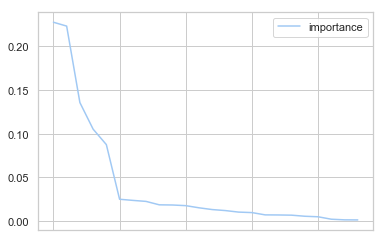

In [58]:
feature_importances = pd.DataFrame(clf_Random_cats.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot()

Based on the feature importance graph we will try to remove features with importance less than 0.02 and see if it will improve the result

In [59]:
feature_importances.head(8)

,importance
Age In Years,0.227586
Animal_Spayed_Neutered_Spayed/Neutered,0.223172
Date_hour,0.135631
Name Category_Name unknown,0.105177
month,0.087481
color_type_Solid,0.024910
Animal_Sex_Male,0.023616
DateHourCategory_midday,0.022451


In [60]:
animals_train_Cats_classification = pd.get_dummies(animals_train_Cats[[ 'month', 'Name Category', 'Age In Years', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory']], drop_first=True)

In [61]:
X = animals_train_Cats_classification
y = animals_train_Cats['OutcomeType'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=282)

In [62]:
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'auto', criterion='gini',n_estimators=500, oob_score =True, max_depth =15)

Train accuracy: 0.93
Test accuracy : 0.78



As we can see it didn’t improve the test result, therefore we will use the model with the full features list

**Final cats model:**

In [63]:
#---------------------------------------------------------------------------------------------------------------------
animals_train_Cats_classification = pd.get_dummies(animals_train_Cats[['MixedBreed', 'month', 'Season', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory','BreedCategory']], drop_first=True)

X = animals_train_Cats_classification
y = animals_train_Cats['OutcomeType'].ravel()

clf_Random_cats = RandomForestClassifier(max_features= 'auto', criterion='gini',n_estimators=500, oob_score =True, max_depth =15).fit(X, y)
#---------------------------------------------------------------------------------------------------------------------

## Dogs Model:

In [64]:
X = animals_train_Dogs_classification
y = animals_train_Dogs['OutcomeType'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=282)

### Random Forest

In [65]:
#---------RandomForestClassifier-------------
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'sqrt', criterion='entropy',n_estimators=50)
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'sqrt', criterion='gini',n_estimators=400, oob_score =True, max_depth =10)
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'auto', criterion='gini',n_estimators=400, max_depth =15)

Train accuracy: 0.97
Test accuracy : 0.56

Train accuracy: 0.64
Test accuracy : 0.59

Train accuracy: 0.75
Test accuracy : 0.59



### xgboost

In [66]:
#---------XGBClassifier-------------
evaluate_model(xgb.XGBClassifier, X_train, y_train, X_test, max_depth=20, n_estimators=500, learning_rate =0.05)
evaluate_model(xgb.XGBClassifier, X_train, y_train, X_test, learning_rate =0.08, n_estimators=500, max_depth=10, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'multi:softprob', nthread=4, seed=27)

c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train accuracy: 0.97
Test accuracy : 0.54



c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train accuracy: 0.95
Test accuracy : 0.55



c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Decision Tree

In [67]:
#---------DecisionTreeClassifier-------------
evaluate_model(DecisionTreeClassifier, X_train, y_train, X_test, max_depth=10, min_samples_split=10,  min_samples_leaf=10)

Train accuracy: 0.62
Test accuracy : 0.56



### Logistic Regression

In [68]:
#---------LogisticRegression-------------
evaluate_model(LogisticRegression, X_train, y_train, X_test)

Train accuracy: 0.59
Test accuracy : 0.58



Based on the accuracy scores we selected the model with highest test score for animal type dogs.
Final selected model is RandomForest with the parameters: max_features= 'auto', criterion='gini',n_estimators=400, max_depth =15

In [69]:
clf_Random_dogs = RandomForestClassifier(max_features= 'auto', criterion='gini',n_estimators=400, max_depth =15).fit(X_train, y_train)

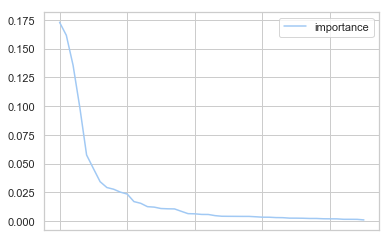

In [70]:
feature_importances = pd.DataFrame(clf_Random_dogs.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot()

Based on the feature importance graph we will try to remove features with importance less than 0.025 and see if it will improve the result

In [71]:
feature_importances.head(9)

,importance
Animal_Spayed_Neutered_Spayed/Neutered,0.172885
Age In Years,0.161579
Date_hour,0.135494
month,0.098701
Name Category_Name unknown,0.057470
AgeCategory_young,0.045793
DateHourCategory_midday,0.034250
Animal_Sex_Male,0.029187
color_type_Solid,0.027713


In [72]:
animals_train_Dogs_classification = pd.get_dummies(animals_train_Dogs[[ 'month', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory']], drop_first=True)

In [73]:
X = animals_train_Dogs_classification
y = animals_train_Dogs['OutcomeType'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=282)

In [74]:
evaluate_model(RandomForestClassifier, X_train, y_train, X_test, max_features= 'auto', criterion='gini',n_estimators=400, max_depth =15)

Train accuracy: 0.79
Test accuracy : 0.56



As we can see it didn’t improve the test result, therefore we will use the model with the full features list

**Final dogs model:**

In [75]:
#---------------------------------------------------------------------------------------------------------------------
animals_train_Dogs_classification = pd.get_dummies(animals_train_Dogs[['MixedBreed', 'month', 'Season', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory','BreedCategory']], drop_first=True)

X = animals_train_Dogs_classification
y = animals_train_Dogs['OutcomeType'].ravel()

clf_Random_dogs = RandomForestClassifier(max_features= 'auto', criterion='gini',n_estimators=400, max_depth =15).fit(X, y)
#---------------------------------------------------------------------------------------------------------------------

**Conclusion:**
    Using Random Forest classifier we managed to get 79% accuracy for cats and 59% accuracy for dogs, we used different model parameters per animal type in order to maximize the accuracy results.

### Handling test data for Kaggle submission:

In [76]:
#Load Test Data
animals_test = pd.read_csv('test.csv', parse_dates=['DateTime'])

#Run all data transformation/aggregation on test data
animals_test['MixedBreed'] = animals_test.Breed.str.contains('Mix')
animals_test['month'] = animals_test['DateTime'].dt.month
animals_test['Season'] = animals_test.month.map(to_season)
animals_test['Name Category'] = animals_test.Name.apply(name_category)
animals_test['Age In Years'] = animals_test.AgeuponOutcome.apply(age_in_years)
animals_test['AgeCategory'] = animals_test['Age In Years'].apply(age_category)
animals_test['Animal_Sex'] = animals_test.SexuponOutcome.apply(Sex)
animals_test['Animal_Spayed_Neutered'] = animals_test.SexuponOutcome.apply(Is_Spayed_Neutered)
animals_test['color_type'] = animals_test.Color.apply(colorType)
animals_test['Date_hour'] = animals_test['DateTime'].dt.hour
animals_test['DateHourCategory'] = animals_test['Date_hour'].apply(Date_Part)

#Split test data per animal type
animals_test_Cats = animals_test[animals_test['AnimalType'] == 'Cat' ]
animals_test_Dogs = animals_test[animals_test['AnimalType'] == 'Dog' ]

#Calculate breed category column per animal type
animals_test_Dogs['BreedCategory'] = animals_test_Dogs['Breed'].apply(TopBreed, args=(breeds_list_dogs,))
animals_test_Cats['BreedCategory'] = animals_test_Cats['Breed'].apply(TopBreed, args=(breeds_list_cats,))

#Final Dogs X_Test
animals_test_Dogs_classification = pd.get_dummies(animals_test_Dogs[['MixedBreed', 'month', 'Season', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory','BreedCategory']], drop_first=True)

#Final Cats X_Test
animals_test_Cats_classification = pd.get_dummies(animals_test_Cats[['MixedBreed', 'month', 'Season', 'Name Category', 'Age In Years', 'AgeCategory', 'Animal_Sex', 'Animal_Spayed_Neutered', 'color_type','Date_hour','DateHourCategory','BreedCategory']], drop_first=True)

c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\kobis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
Dogs_y_pred = clf_Random_dogs.predict(animals_test_Dogs_classification)
Cats_y_pred = clf_Random_cats.predict(animals_test_Cats_classification)

In [78]:
Cats_df_pred = pd.merge(animals_test_Cats, pd.DataFrame(Cats_y_pred),  how='left',left_index = True, right_index = True)
Cats_df_pred.rename(columns={0: 'y_pred'}, inplace=True)

In [79]:
Dogs_df_pred = pd.merge(animals_test_Dogs, pd.DataFrame(Dogs_y_pred),  how='left',left_index = True, right_index = True)
Dogs_df_pred.rename(columns={0: 'y_pred'}, inplace=True)

In [80]:
Test_Final_Prediction = pd.concat([Cats_df_pred,Dogs_df_pred])
Test_Final_Prediction.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,MixedBreed,month,...,Name Category,Age In Years,AgeCategory,Animal_Sex,Animal_Spayed_Neutered,color_type,Date_hour,DateHourCategory,BreedCategory,y_pred
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,True,1,...,Name exist,1.0,young,Male,Spayed/Neutered,Solid,12,midday,Domestic Shorthair,Adoption
6,7,Bobo,2014-03-12 09:45:00,Cat,Neutered Male,13 years,Domestic Medium Hair Mix,Brown Tabby/White,True,3,...,Name exist,13.0,old,Male,Spayed/Neutered,Mixed,9,morning,Domestic Medium Hair,Transfer
7,8,Abby,2014-06-25 08:27:00,Cat,Spayed Female,6 months,Domestic Shorthair Mix,Brown Tabby,True,6,...,Name exist,0.5,young,Female,Spayed/Neutered,Solid,8,morning,Domestic Shorthair,Transfer
18,19,Freckles,2014-06-16 12:49:00,Cat,Spayed Female,3 years,Domestic Shorthair Mix,Torbie,True,6,...,Name exist,3.0,young adult,Female,Spayed/Neutered,Solid,12,midday,Domestic Shorthair,Transfer
19,20,NaN,2014-02-11 19:27:00,Cat,Intact Female,4 years,Domestic Shorthair Mix,Torbie,True,2,...,Name unknown,4.0,young adult,Female,Intact,Solid,19,lateday,Domestic Shorthair,Transfer


In [81]:
# Create file for kaggle submission
Test_Final_Prediction = pd.get_dummies(Test_Final_Prediction[['ID','y_pred']],prefix=None)
Test_Final_Prediction = Test_Final_Prediction.rename(columns={'y_pred_Adoption':'Adoption', 'y_pred_Died':'Died', 'y_pred_Euthanasia':'Euthanasia', 'y_pred_Return_to_owner':'Return_to_owner', 'y_pred_Transfer':'Transfer'})
Test_Final_Prediction.to_csv('Submmition_NG_SK.csv')